# Anomaly detection with Auto-Encoder

Inspired by [Vegard Flovik's post on Medium](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7)<br>
Data from [here](http://data-acoustics.com/measurements/bearing-faults/bearing-4/)

### Purpose:
We try to detect anomalies from "IMS Bearing Data". We used "Test1" data which has 8 channels;
<br><br>
Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4;<br>
Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8. <br>
<br>
Data recorded every 10 minutes (except the first 43 files were taken every 5 minutes).
<br>
At the end of the test-to-failure experiment, inner race defect occurred inbearing 3 and roller element defect in bearing 4.


#### Steps:
1. prepare data
2. visualize data
3. build autoencoder ANN
4. get results
5. ...
6. profit?

In [1]:
import numpy as np


from get_data import get_data_sets

In [2]:
# number of training records = 20
# number of testing records = 10
# every xth records in dataset
train, test = get_data_sets("./data",20,10,2)
print(train.shape)
print(test.shape)

(409600, 8)
(204800, 8)


# Visualize data

In [3]:
train[:10]

array([[-0.022, -0.039, -0.183, -0.054, -0.105, -0.134, -0.129, -0.142],
       [-0.105, -0.017, -0.164, -0.183, -0.049,  0.029, -0.115, -0.122],
       [-0.183, -0.098, -0.195, -0.125, -0.005, -0.007, -0.171, -0.071],
       [-0.178, -0.161, -0.159, -0.178, -0.1  , -0.115, -0.112, -0.078],
       [-0.208, -0.129, -0.261, -0.098, -0.151, -0.205, -0.063, -0.066],
       [-0.232, -0.061, -0.281, -0.125,  0.046, -0.088, -0.078, -0.078],
       [-0.112, -0.132, -0.181, -0.186, -0.132, -0.051, -0.132, -0.076],
       [-0.054, -0.107, -0.173, -0.134, -0.164,  0.002, -0.146, -0.125],
       [-0.159, -0.032, -0.161, -0.181, -0.11 , -0.044, -0.173, -0.137],
       [-0.225, -0.044, -0.09 , -0.159, -0.1  , -0.151, -0.139, -0.076]])

In [4]:
test[:10]

array([[-0.186,  0.01 ,  0.056, -0.037, -0.334,  0.039, -0.193,  0.034],
       [-0.115, -0.176,  0.029, -0.068, -0.444, -0.464, -0.186, -0.054],
       [ 0.049, -0.181,  0.015, -0.054, -0.388, -0.166, -0.183, -0.066],
       [-0.056, -0.234, -0.161,  0.081,  0.071, -0.337, -0.061, -0.083],
       [-0.129, -0.034, -0.054,  0.032, -0.347,  0.063,  0.022, -0.042],
       [-0.208, -0.139, -0.059,  0.012, -0.134,  0.078, -0.042,  0.076],
       [-0.244, -0.134, -0.195, -0.09 ,  0.139, -0.22 , -0.337,  0.132],
       [-0.242, -0.1  , -0.386, -0.078,  0.054, -0.022, -0.149,  0.125],
       [-0.22 , -0.015, -0.403, -0.129, -0.022, -0.166, -0.083, -0.459],
       [-0.322,  0.042, -0.247, -0.22 ,  0.085, -0.32 , -0.046, -0.085]])

In [5]:
test[-10:]

array([[-0.015, -0.01 ,  0.159, -0.078, -0.042, -0.049, -0.176, -0.105],
       [-0.095, -0.173,  0.107, -0.015, -0.244, -0.09 ,  0.   , -0.09 ],
       [-0.02 , -0.203,  0.049,  0.024, -0.767,  0.728, -0.012,  0.059],
       [-0.066, -0.042,  0.022, -0.046, -0.994,  0.239, -0.071, -0.044],
       [-0.22 , -0.125, -0.127, -0.105, -0.405,  0.662, -0.107, -0.034],
       [-0.117, -0.117, -0.085, -0.227,  0.525, -0.21 , -0.105, -0.137],
       [-0.029, -0.071,  0.005, -0.115, -0.01 , -0.337, -0.139, -0.249],
       [-0.183,  0.09 , -0.12 , -0.017, -0.166,  0.437, -0.137, -0.105],
       [-0.359,  0.049, -0.117,  0.083, -0.415,  0.417, -0.049, -0.081],
       [-0.281,  0.01 , -0.2  ,  0.   ,  0.046, -0.237, -0.1  ,  0.042]])

In [6]:
print("-----------------------------------------------------------------")
print("max values in training : ", train.max(axis=0))
print("max values in testing : ", test.max(axis=0))
print("-----------------------------------------------------------------")
print("min values in training : ", train.min(axis=0))
print("min values in testing : ", test.min(axis=0))

-----------------------------------------------------------------
max values in training :  [0.503 0.701 0.398 0.286 0.596 0.474 0.52  0.449]
max values in testing :  [0.564 0.657 0.586 0.496 4.998 3.884 0.894 0.708]
-----------------------------------------------------------------
min values in training :  [-0.745 -0.564 -0.725 -0.652 -0.657 -0.784 -0.662 -0.671]
min values in testing :  [-0.815 -0.72  -0.991 -0.83  -4.875 -5.    -1.047 -1.157]


# Neural Network

In [7]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Input
from keras.layers import Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [8]:
inputs = Input(train.shape[1:])
inputs


<tf.Tensor 'input_1:0' shape=(?, 8) dtype=float32>

In [9]:
dense_1 = Dense(4, activation='relu', name='dense_1')(inputs)
dense_1

<tf.Tensor 'dense_1/Relu:0' shape=(?, 4) dtype=float32>

In [10]:
dense_2 = Dense(2, activation='relu', name='dense_2')(dense_1)
dense_2

<tf.Tensor 'dense_2/Relu:0' shape=(?, 2) dtype=float32>

In [11]:
dense_3 = Dense(4, activation='relu', name='dense_3')(dense_2)
dense_3

<tf.Tensor 'dense_3/Relu:0' shape=(?, 4) dtype=float32>

In [12]:
dense_4 = Dense(train.shape[1], name='dense_4')(dense_3)
dense_4

<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 8) dtype=float32>

In [13]:
prediction = Activation('tanh', name='tanh')(dense_4)
prediction

<tf.Tensor 'tanh/Tanh:0' shape=(?, 8) dtype=float32>

In [14]:
model = Model(outputs=prediction,inputs = inputs)

In [15]:
adam = Adam(lr=0.0001)
adam

In [16]:
model.compile(optimizer=adam, loss='mean_squared_error',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
tanh (Activation)            (None, 8)                 0         
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


In [17]:
# params
batch_size = 50

In [18]:
# tensorboard
log_dir = "./tensorboard/autoencoder/"
tensorboard = TensorBoard(log_dir=log_dir,batch_size=batch_size)

In [19]:
# x and y are same.
model.fit(x = train, y = train, batch_size=50, epochs=50,shuffle = True,
              callbacks=[tensorboard])

Epoch 1/50
409600/409600 [==============================] - 10s 25us/step - loss: 0.0055 - acc: 0.2560
Epoch 2/50
409600/409600 [==============================] - 11s 26us/step - loss: 0.0039 - acc: 0.3799
Epoch 3/50
409600/409600 [==============================] - 9s 22us/step - loss: 0.0039 - acc: 0.3992
Epoch 4/50
409600/409600 [==============================] - 11s 26us/step - loss: 0.0039 - acc: 0.4067
Epoch 5/50
409600/409600 [==============================] - 11s 26us/step - loss: 0.0039 - acc: 0.4109
Epoch 6/50
409600/409600 [==============================] - 10s 23us/step - loss: 0.0039 - acc: 0.4133
Epoch 7/50
409600/409600 [==============================] - 10s 23us/step - loss: 0.0039 - acc: 0.4147
Epoch 8/50
409600/409600 [==============================] - 10s 25us/step - loss: 0.0039 - acc: 0.4161
Epoch 9/50
409600/409600 [==============================] - 11s 26us/step - loss: 0.0039 - acc: 0.4171
Epoch 10/50
409600/409600 [==============================] - 10s 24us/step

In [20]:
predicted_test = model.predict(test)

In [21]:
MSE = []
n = test.shape[1]
for i in range(len(test)):
    MSE.append( np.sum((test[i] - predicted_test[i])**2)/n)
    
MSE = np.array(MSE)
MSE

array([0.00874253, 0.01801154, 0.00489532, ..., 0.0055871 , 0.01636842,
       0.0087667 ])

# Lets assume a threshold for loss value

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [25, 15]

In [23]:
x = list(range(MSE.shape[0]))

In [24]:
threshold = 0.2

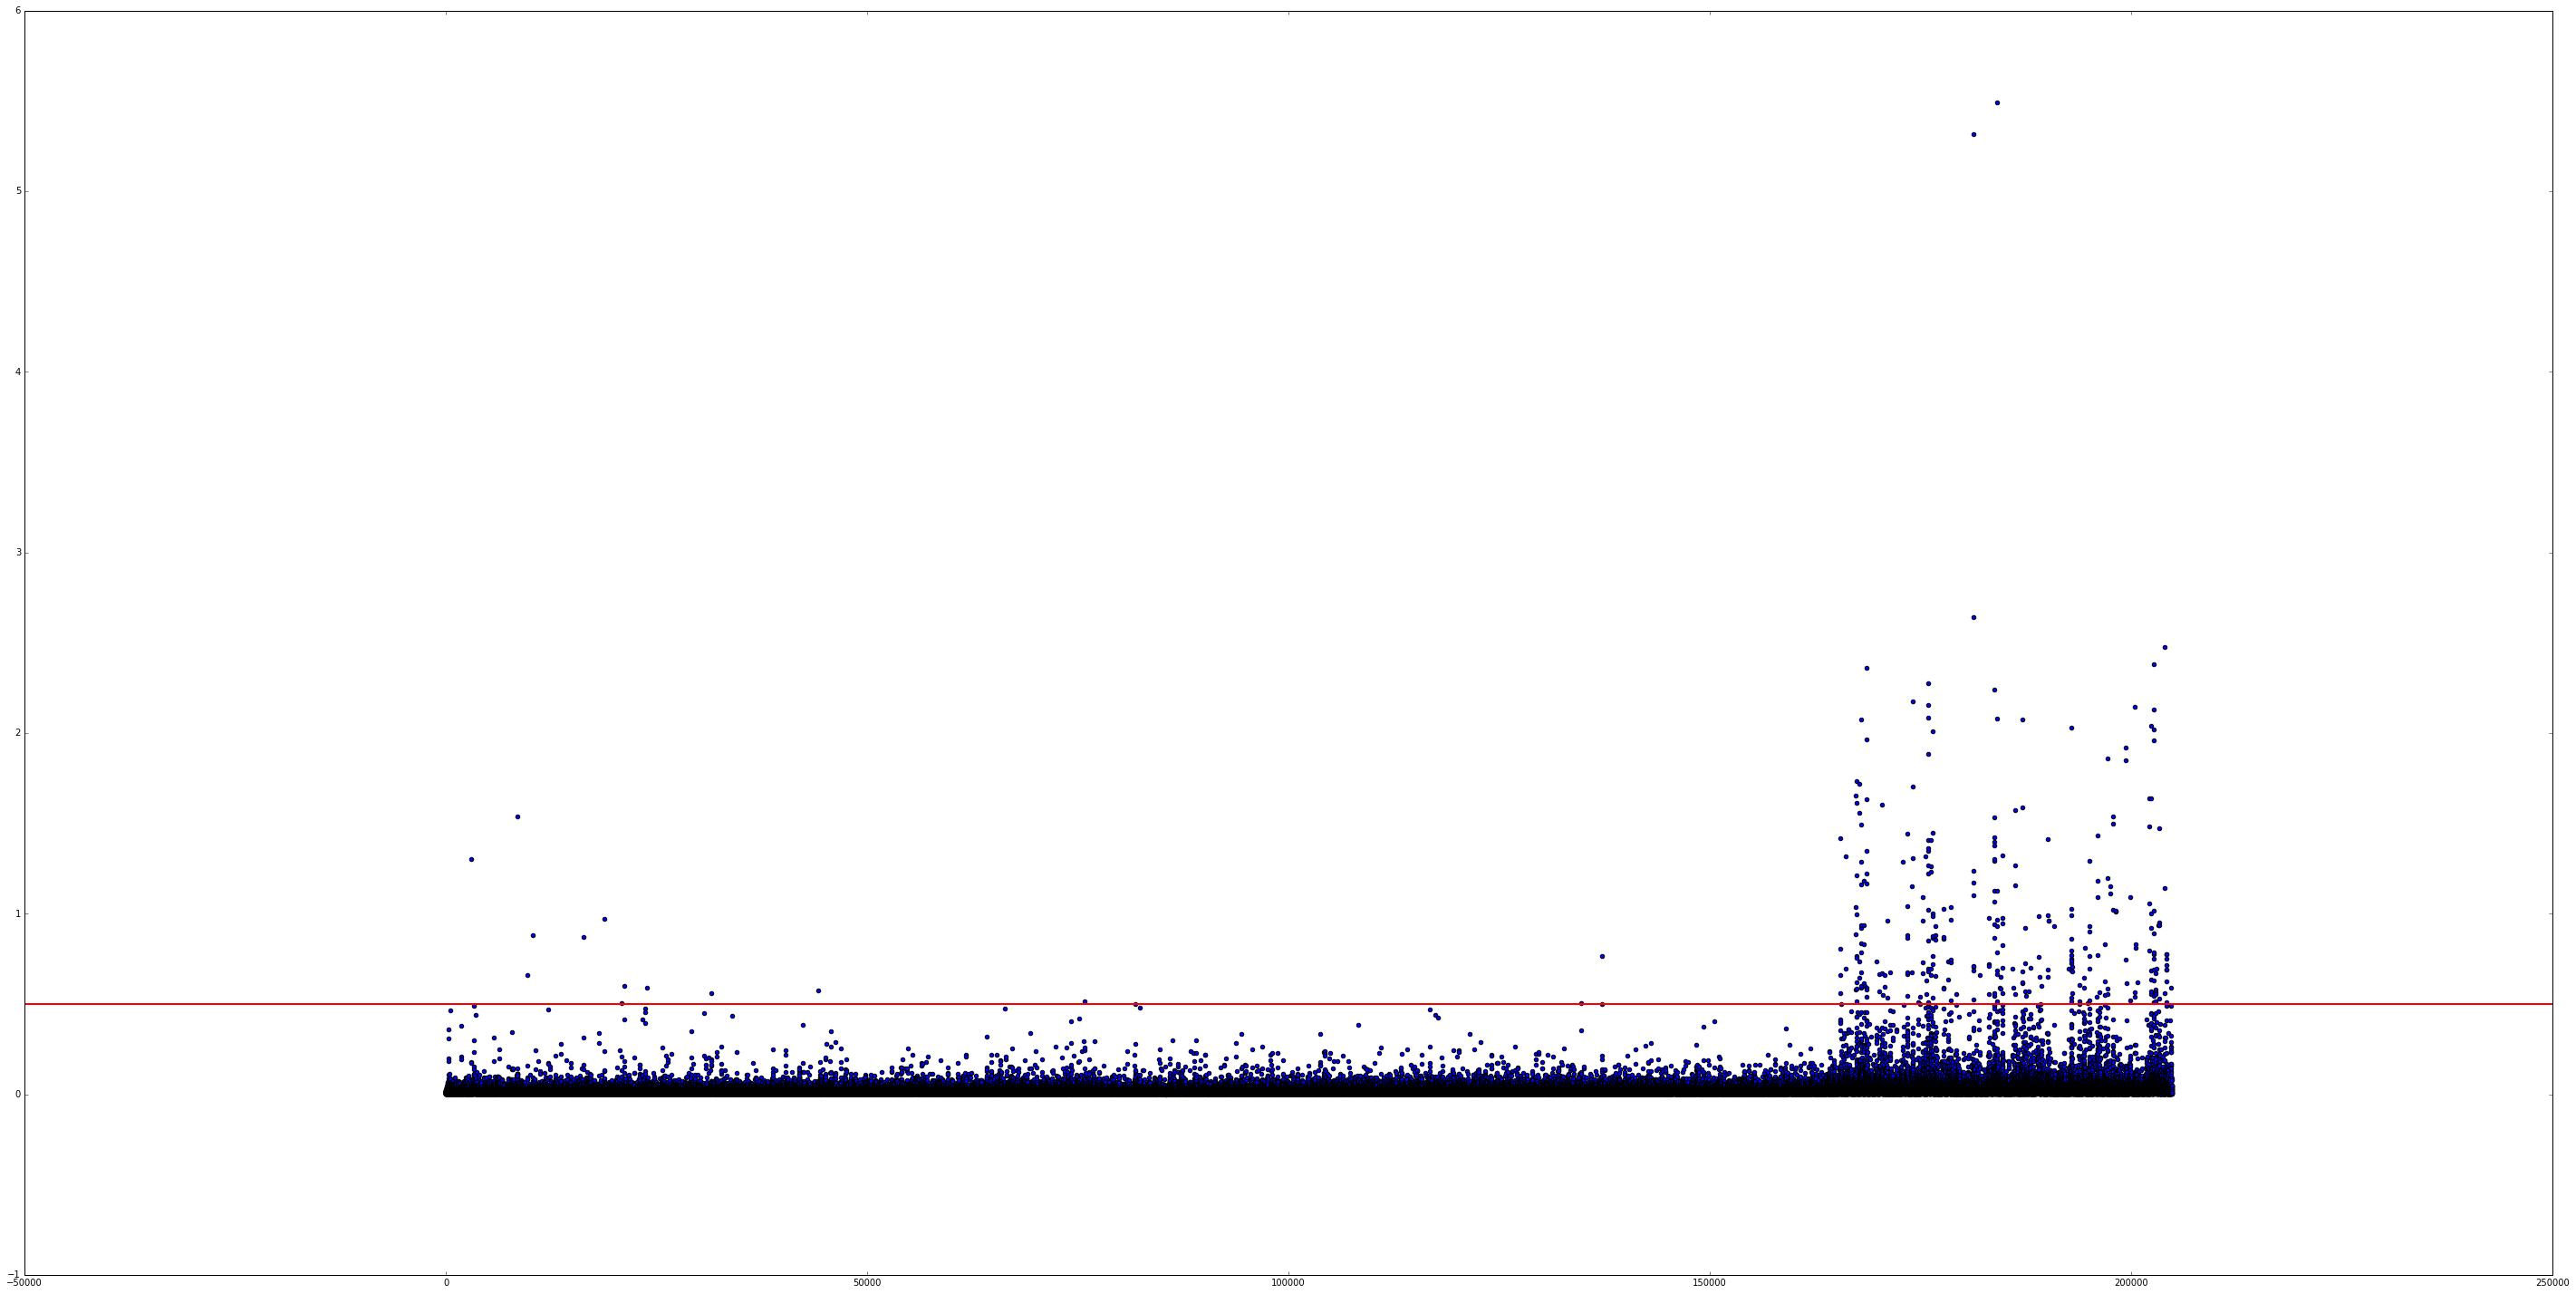

In [25]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.axhline(y=0.5, color='r',linewidth=2 ,linestyle='-')
plt.scatter(x, MSE)


# What to do next?
1. Improve training accuracy (maybe after many steps, we can reach some kind of overfit which might be good for this task)